Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses XGBoost to predict Churn, and GridSearchCV to perform hyperparameter tuning.   

**Note:**
- only include license activation starting from 1/1/2019.
- both setup completed and not completed accounts are included.

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/XGBoost/Churn_XGBoost_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 7, 21)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2019, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = False
mlflow.log_param("Setup complete", registered_only)

2020/09/29 16:05:38 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
 - be included in your $PATH
 - be set via $GIT_PYTHON_GIT_EXECUTABLE
 - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
 - quiet|q|silence|s|none|n|0: for no warning or exception
 - warn|w|warning|1: for a printed warning
 - error|e|raise|r|2: for a raised exception

Example:
 export GIT_PYTHON_REFRESH=quiet

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

**Impose further limit on licenses**

In [0]:
# df = df[df.Licenses >= license_limit]
# df.shape

Out[14]: (2560, 24)

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
0,15236,50,LOUIS LATOUR,10,False,0,14186,LOUIS LATOUR,SAN RAFAEL,None,94903,US,en-US,2019-02-07,2019-08-26,2019-08-29 00:11:55.580,203,1,14,0,0,0,0,0
1,15263,50,MESSNER REEVES LLP,10,False,0,14205,MESSNER REEVES LLP,DENVER,None,80202,US,en-US,2019-02-08,2020-04-03,2020-04-03 00:02:12.830,420,1,23,0,0,0,0,0
2,15985,50,MORGAN,5,False,0,14870,MORGAN,LOUISVILLE,None,40215,US,en-US,2019-04-25,2019-07-28,2019-07-28 00:17:25.230,94,1,3,0,0,0,0,0
3,17359,50,HARTMAN FARMS,5,False,0,16668,HARTMAN FARMS,KOKOMO,None,46901,US,en-US,2019-09-09,2019-10-13,2019-10-13 00:13:16.100,34,1,4,0,0,0,0,0
4,17372,50,SGA PRODUCTION SERVICES,5,False,0,16677,SGA PRODUCTION SERVICES,NAPERVILLE,None,60563,US,en-US,2019-09-10,2020-02-06,2020-02-06 00:01:17.140,149,1,21,0,0,0,0,0


In [0]:
df.describe(include='all')

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
count,2560.000000,2560.0,2560,2560.000000,2560,2560.0,2560.000000,2560,2492,468,2484,2560,2560,2560,1754,1747,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000,2560.000000
unique,NaN,NaN,2515,NaN,2,NaN,NaN,2510,1357,47,1832,3,1,483,477,1741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,EXCEL REAL ESTATE MANAGEMENT,NaN,False,NaN,NaN,EXCEL REAL ESTATE MANAGEMENT,LOUISVILLE,CA,48180,US,en-US,2020-03-23 00:00:00,2020-02-06,2019-09-01 00:13:37.370000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,9,NaN,1998,NaN,NaN,9,52,69,12,2539,2560,34,14,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00,NaN,2019-01-14 00:11:00.370000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-15 00:00:00,NaN,2020-07-16 00:04:48.450000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,23383.069141,50.0,NaN,13.593750,NaN,0.0,16682.785938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.484375,0.682422,16.759766,0.419922,774.719922,74.066016,38.842578,17.224219
std,11158.516671,0.0,NaN,7.580273,NaN,0.0,1991.013462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.182767,0.465625,35.170146,2.478164,4659.688540,1028.930956,399.549758,295.497983
min,14984.000000,50.0,NaN,2.000000,NaN,0.0,2520.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16023.750000,50.0,NaN,10.000000,NaN,0.0,14899.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.750000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Categorical feature distributions

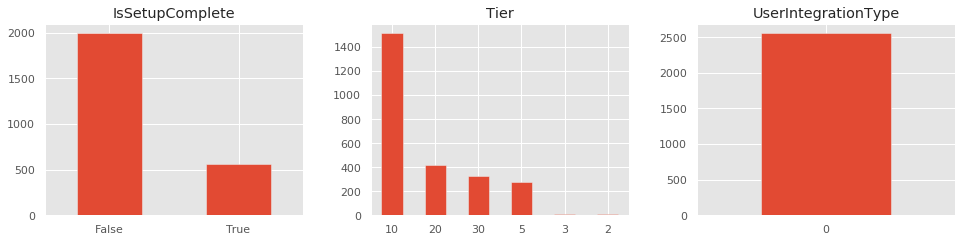

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

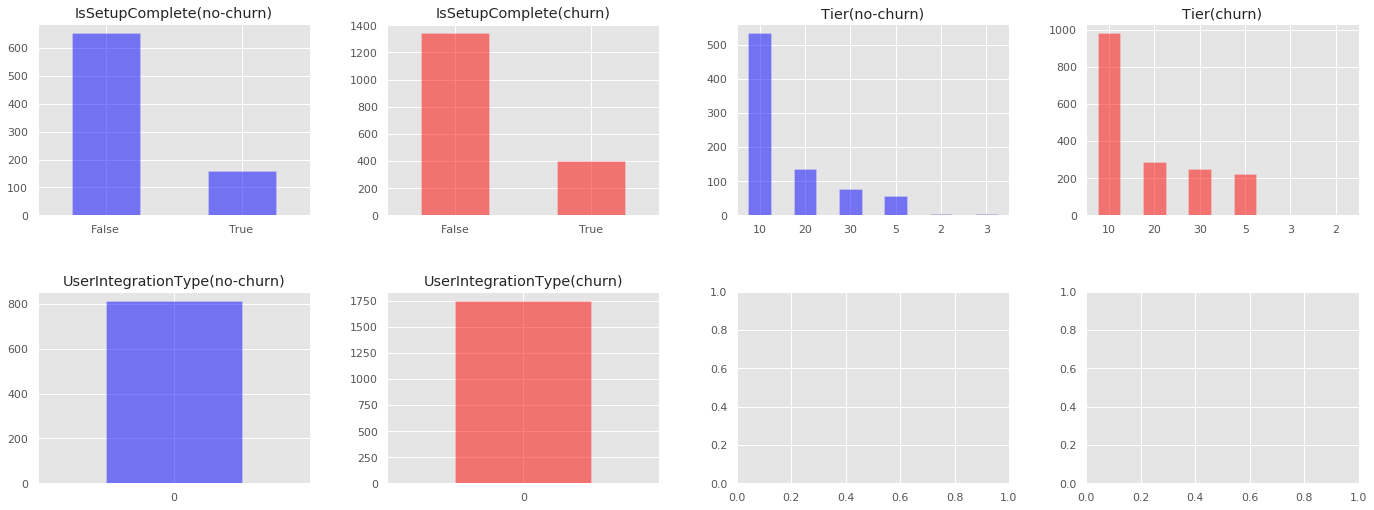

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('IsSetupComplete(no-churn)')
df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('IsSetupComplete(churn)')

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('UserIntegrationType(churn)')

fig.tight_layout(pad=4.0)

Numerical feature distributions

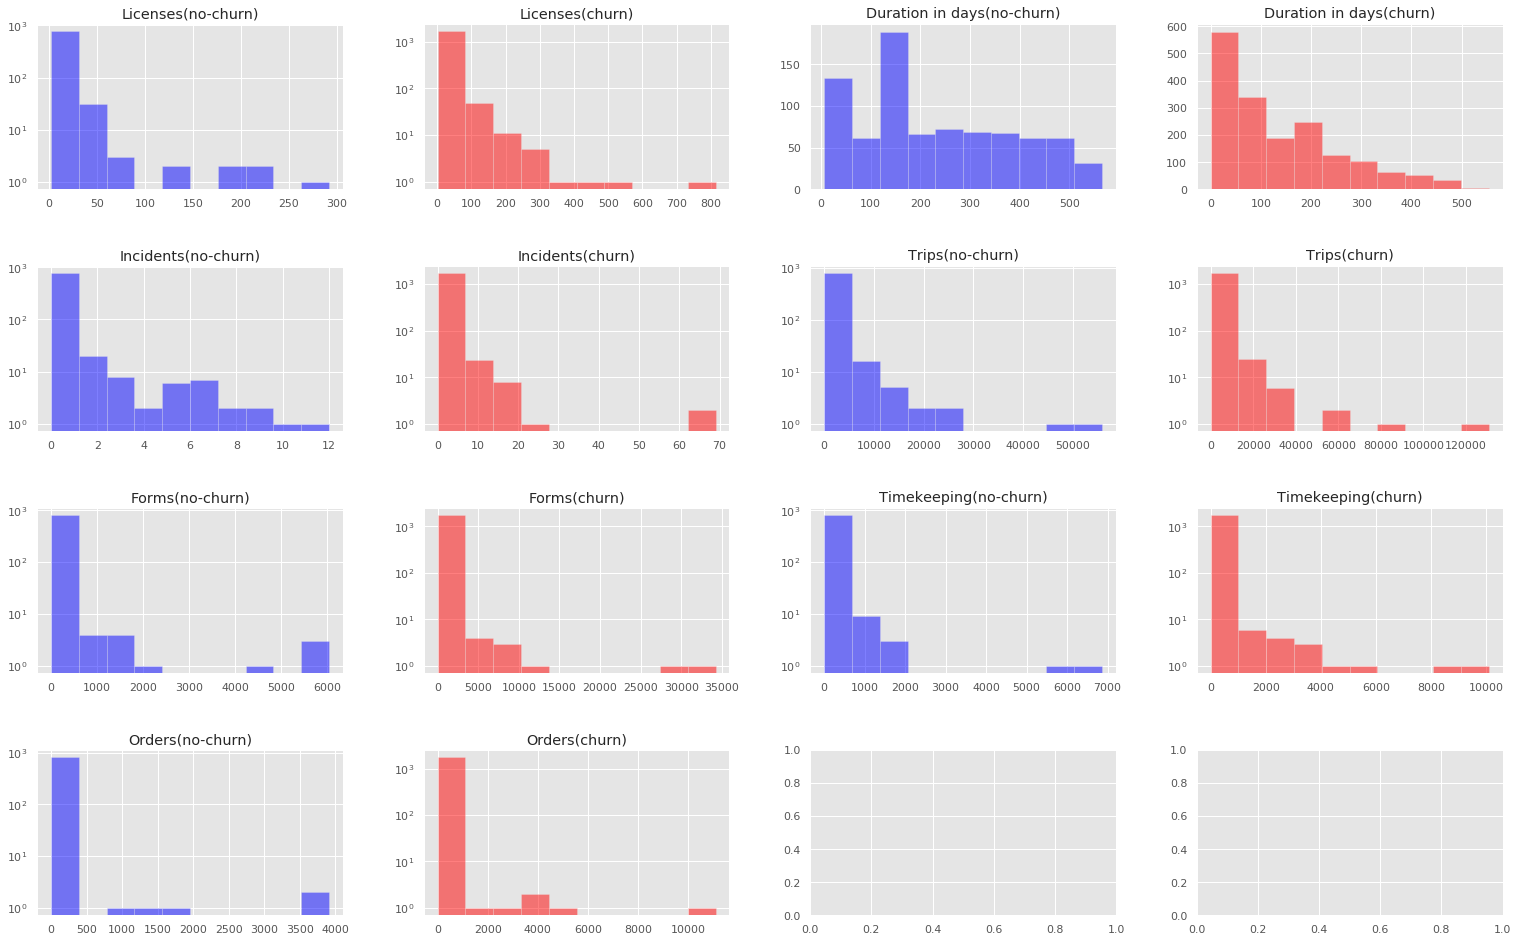

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

Correlation Matrix and Heatmap

In [0]:
df_corr = df[categorical_features + [target] + numerical_features]

df_corr.corr(method='kendall')

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
IsSetupComplete,1.000000,0.085114,NaN,0.039486,0.136438,0.057260,0.436891,0.700355,0.513938,0.549468,0.406417
Tier,0.085114,1.000000,NaN,0.010925,0.130247,-0.004375,0.036303,0.019762,0.302643,0.243842,0.230583
UserIntegrationType,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,0.039486,0.010925,NaN,1.000000,0.181458,-0.236046,0.032110,-0.017637,0.011574,0.034651,0.014837
Licenses,0.136438,0.130247,NaN,0.181458,1.000000,0.059031,0.183818,0.174615,0.141216,0.138606,0.102092
Duration,0.057260,-0.004375,NaN,-0.236046,0.059031,1.000000,0.076369,0.096277,0.057405,0.084643,0.052035
Incidents,0.436891,0.036303,NaN,0.032110,0.183818,0.076369,1.000000,0.497255,0.265196,0.317435,0.222208
Trips,0.700355,0.019762,NaN,-0.017637,0.174615,0.096277,0.497255,1.000000,0.327852,0.421634,0.299887
Forms,0.513938,0.302643,NaN,0.011574,0.141216,0.057405,0.265196,0.327852,1.000000,0.579705,0.525896
Timekeeping,0.549468,0.243842,NaN,0.034651,0.138606,0.084643,0.317435,0.421634,0.579705,1.000000,0.479721


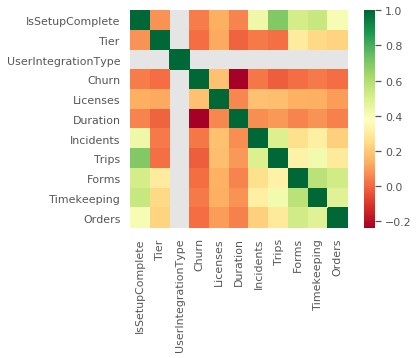

In [0]:
plt.style.use('ggplot')

sns.heatmap(df_corr.corr(method='kendall'), square=True, cmap='RdYlGn')

Sampled dataframe

In [0]:
df_sampled = df.sample(replace=False, frac=1, random_state=42)

df_sampled.shape

Out[24]: (2560, 24)

**Training**

In [0]:
df_final = df_sampled[categorical_features + [target] + numerical_features]

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

In [0]:
# training the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = XGBClassifier(random_state=42)

# param_grid = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 1),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth": randint(3, 10), # default 6
#     "n_estimators": randint(100, 150), # default 100
#     "subsample": uniform(0.6, 0.4)
# }

# tree_cv = RandomizedSearchCV(clf, param_distributions=param_grid, random_state=42, n_iter=200, cv=5, return_train_score=True)

param_grid = {'max_depth': [5,6,7], 
              'learning_rate': np.linspace(0.1, 0.2, 5),
              'subsample': [1],
              'colsample_bytree': [0.8, 0.9, 1],
              'gamma': np.linspace(0.8, 5, 5),
              'n_estimators': [120]
             }

tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)

tree_cv.fit(X_train, np.ravel(y_train))

pred = tree_cv.predict(X_test)

print("Tuned XGBoost: {}".format(tree_cv.best_params_))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", tree_cv.best_params_)
mlflow.sklearn.log_model(tree_cv, "model")
mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))


Tuned XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.8, 'learning_rate': 0.15000000000000002, 'max_depth': 6, 'n_estimators': 120, 'subsample': 1}
Accuracy of XGBoost classifier on test set: 0.78

**Testing **

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.69 0.54 0.60 205
 1 0.80 0.89 0.84 435

 accuracy 0.78 640
 macro avg 0.75 0.71 0.72 640
weighted avg 0.77 0.78 0.77 640

**Model interpretation**

Get model, class names & feature names

In [0]:
model = tree_cv.best_estimator_
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.8, gamma=0.8, gpu_id=-1,
 importance_type='gain', interaction_constraints='',
 learning_rate=0.15000000000000002, max_delta_step=0, max_depth=6,
 min_child_weight=1, missing=nan, monotone_constraints='()',
 n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=42,
 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
 tree_method='exact', validate_parameters=1, verbosity=None)
Feature names: ['IsSetupComplete', 'Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

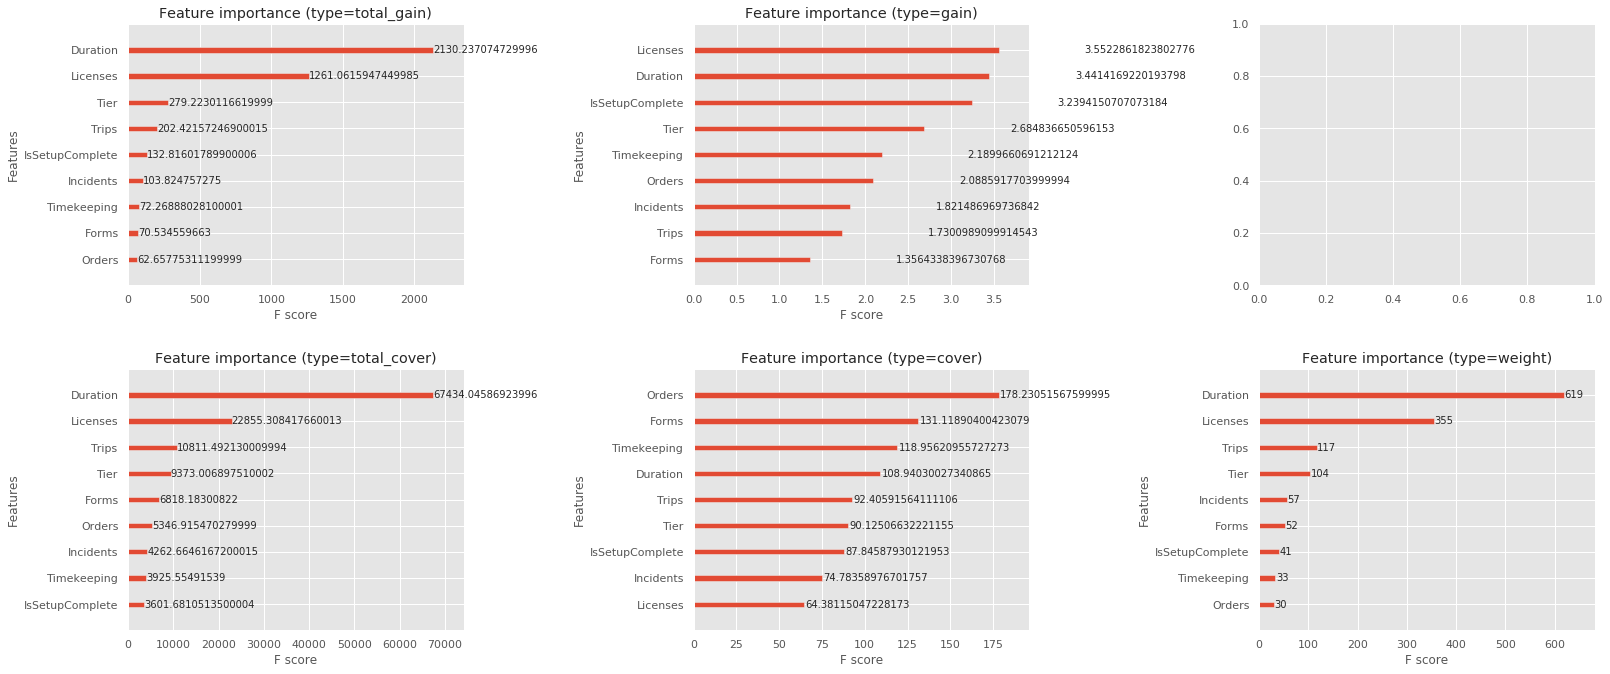

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)

SHAP interpretation  

**Note**: Currently databricks installs XGBoost 1.1.1 that doesn't support SHAP.  
An open issue can be found [here](https://github.com/slundberg/shap/issues/1215). A workaround is to downgrade XGBoost to 1.0.0.

In [0]:
# import shap

# plt.style.use('ggplot')

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)

# print(len(shap_values[0]))
# print(shap_values[0][0])

In [0]:
# RGB_val = 255
# blue = (0/RGB_val, 191/RGB_val, 255/RGB_val)
# red= (255/RGB_val, 0/RGB_val, 0/RGB_val)
# colors = [red, blue]
# cmap = mpl.colors.ListedColormap(colors, name="CustomColors")

# shap.summary_plot(shap_values, X_train, plot_type="bar", color=cmap)

Tree visualization    

**Note**: xgboost.plot_tree is internally implemented with graphviz that will not work with our clusters.

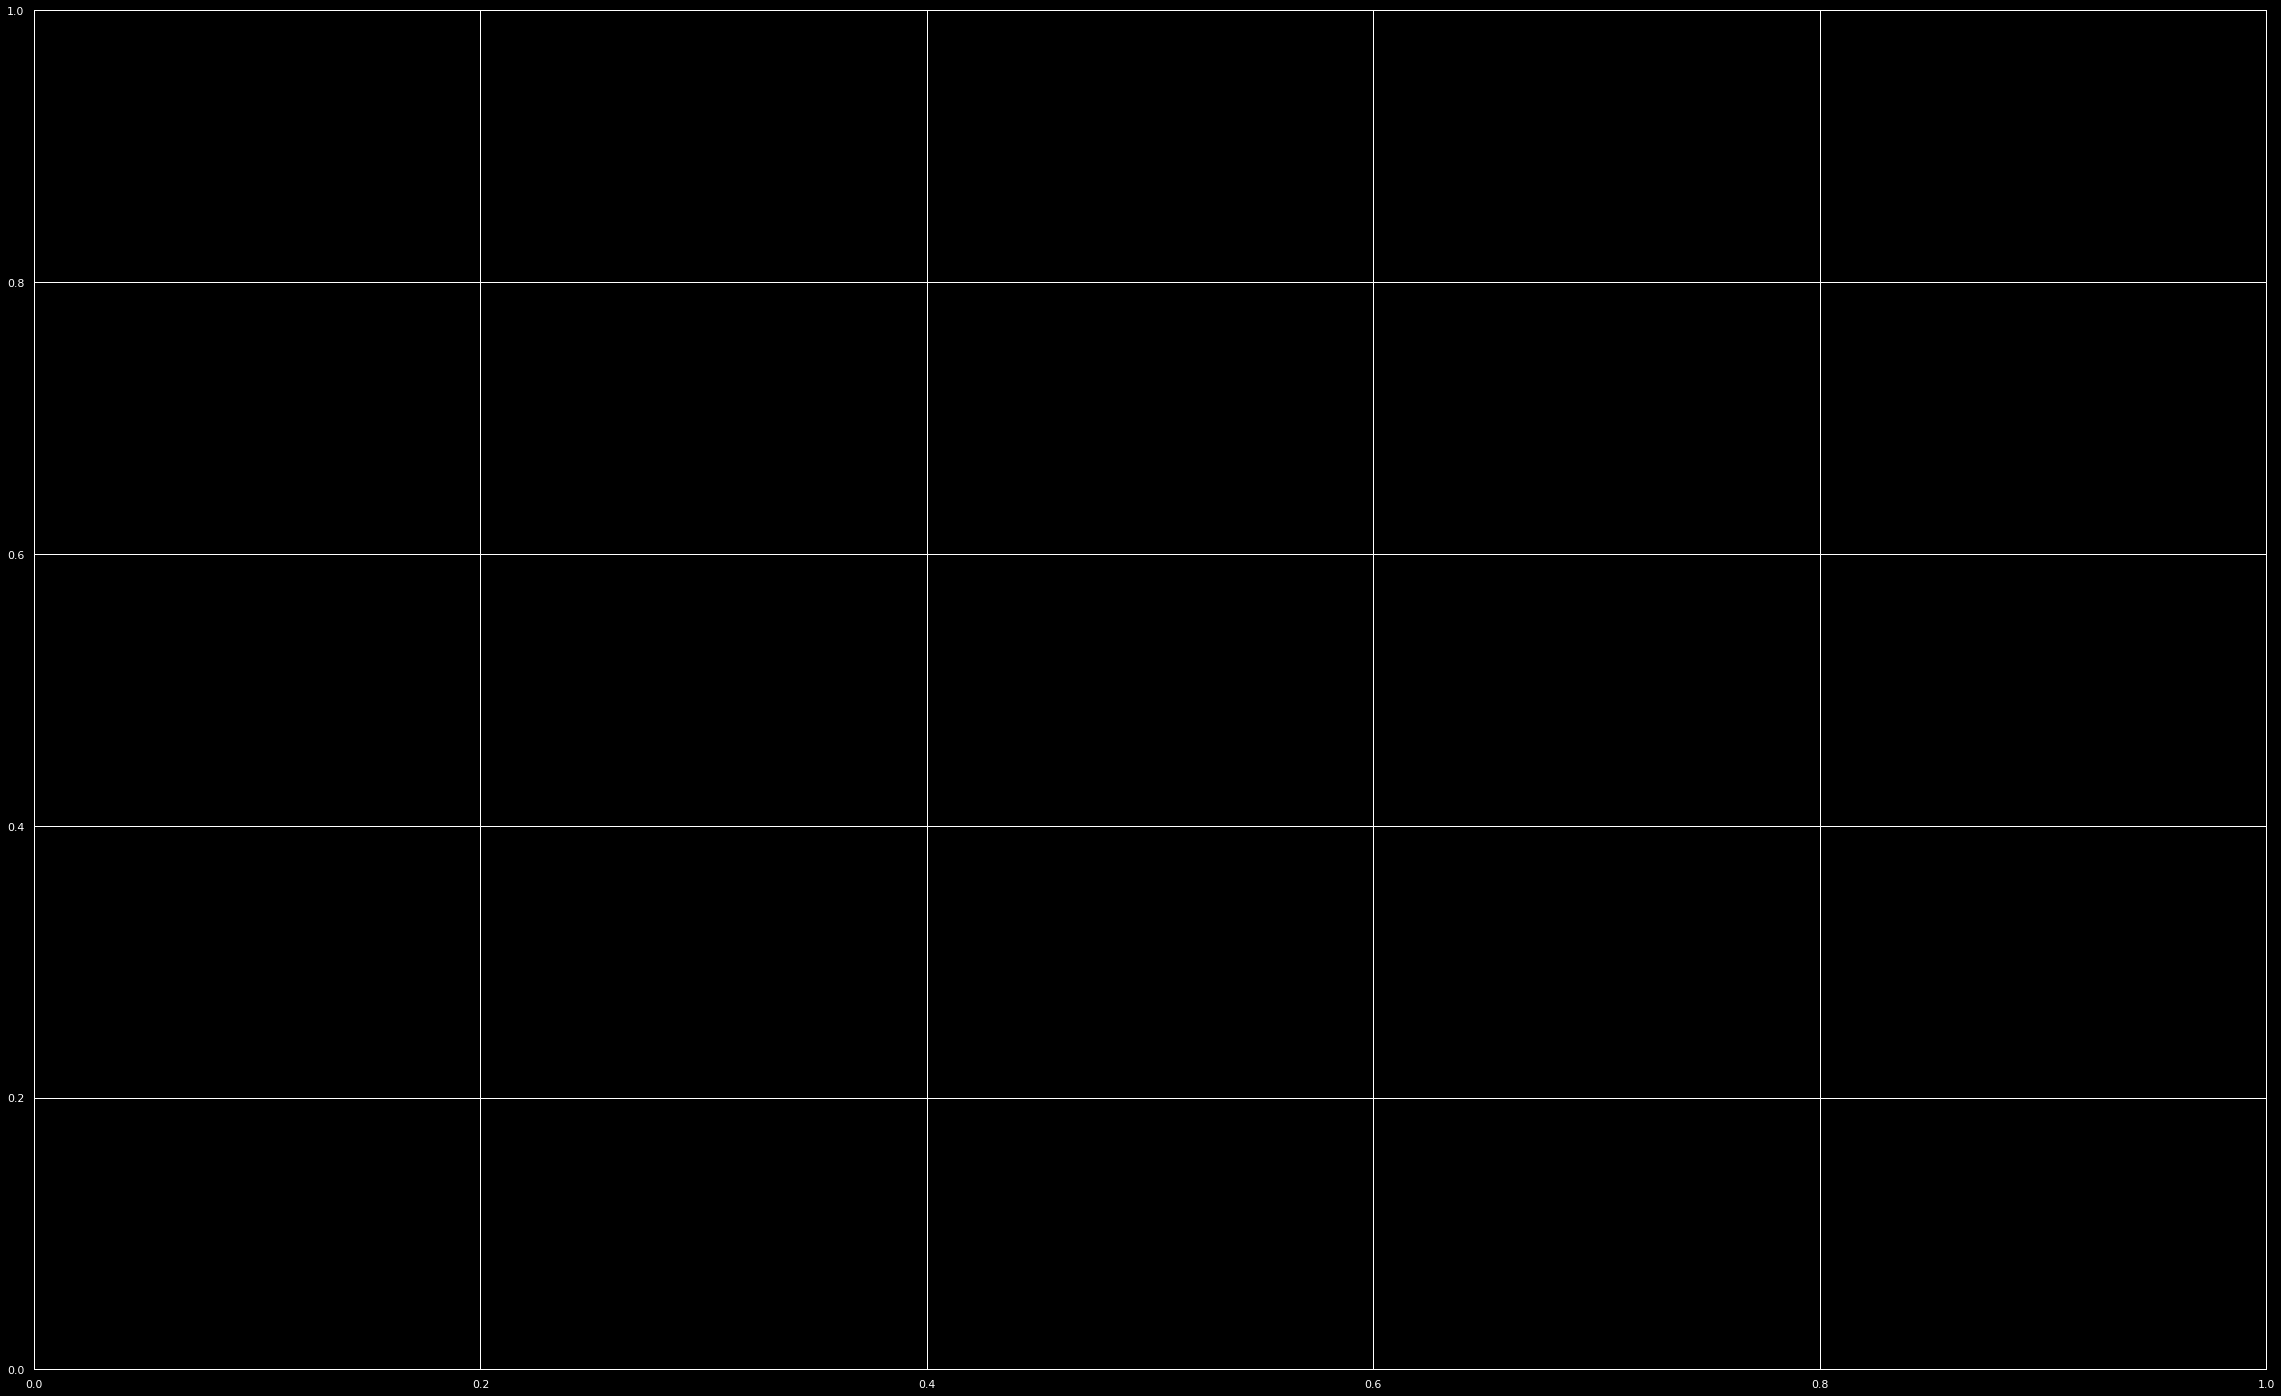

In [0]:
from xgboost import plot_tree

plt.style.use('dark_background')
mpl.rcParams['text.color'] = 'black'

fig, ax = plt.subplots(figsize=(40, 25))

plot_tree(model, num_trees=4, ax=ax)

plt.show()

In [0]:
mlflow.end_run()